# Sub-Task 6-7 (Frozen Lake Problem, Temporal Difference):

In [1]:
#Imports of the necessary libraries
import gym
import numpy as np
import sys
import random
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
"""
This code is adapted from:

https://github.com/alexParmar488/OpenAI-Gym-Environment-Exploration

I combined the classes into one file, tweaked the graph output dependent on the agent in question 

All credit goes to the author.

"""

'\nThis code is adapted from:\n\nhttps://github.com/alexParmar488/OpenAI-Gym-Environment-Exploration\n\nI combined the classes into one file, tweaked the graph output dependent on the agent in question \n\nAll credit goes to the author.\n\n'

### Random

In [3]:
#Random Class to be used with Frozen Lake
class Random():
    def __init__(self):
        super().__init__()

    #The training action is any random action from within the environment action space
    def action(self, env):
        return env.action_space.sample()

### Q-Learner for Frozen Lake & Cart-Pole

In [4]:
#Q-Learner Class to be used with Frozen Lake & Cart-Pole for comparison
class Qlearner():
    def __init__(self, parameters):
        self.alpha = parameters['alpha']
        self.gamma = parameters['gamma']
        self.epsilon = parameters['epsilon']
        super().__init__()
    
    #Q_LEARNER METHODS FOR FROZEN LAKE
    #Initializes the q-table for the frozen lake 
    def initialize_frozen_lake_q_table(self, env):
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])
        
    #Method defines the training action for q-learning for the frozen lake
    def frozen_lake_training_action(self, env, observation):
        self.previous_observation = observation
        if random.uniform(0, 1) < self.epsilon:
            return env.action_space.sample() # explore
        else:
            return np.argmax(self.q_table[observation]) # exploit/ use the highest q-value
        
    #Method evaluates the action for frozen lake
    def frozen_lake_evaluation_action(self, observation):
        return np.argmax(self.q_table[observation])
    
    #Updates the previous observation qtable entry with the reward gained,
    #Uses the maximum/best future option always
    #Updates the q-value
    def frozen_lake_update(self, observation, action, reward):
        old_value = self.q_table[self.previous_observation, action]
        next_max = np.max(self.q_table[observation])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[self.previous_observation, action] = new_value
        
    #Q-LEARNER METHODS FOR CART_POLE
    #Initializes the q-table for the cart-pole
    def initialize_cartpole_q_table(self, env):
        obs_space = CARTPOLE_POSITION_BUCKETS * CARTPOLE_VELOCITY_BUCKETS * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        self.q_table = np.zeros([obs_space, env.action_space.n])

        #establish weak priors to optimise training - if theta < 0, move left, if theta > 0 move right
        for i in range(obs_space):
            if (i % (CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS) < (CARTPOLE_THETA_BUCKETS / 2)):
                self.q_table[i][0] = 0.1
            elif (i % (CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS) >= (CARTPOLE_THETA_BUCKETS / 2)):
                self.q_table[i][1] = 0.1
                
    #Method defines the training action for q-learning for cart-pole
    def cartpole_training_action(self, env, observation):
        self.previous_observation = observation
        if random.uniform(0, 1) < self.epsilon:
            return env.action_space.sample() # explore
        else:
            return np.argmax(self.q_table[self._cartpole_obs_index(observation)]) # exploit
        
    #Method evaluates the action for cart-pole
    def cartpole_evaluation_action(self, observation):
        return np.argmax(self.q_table[self._cartpole_obs_index(observation)])

    #Updates the previous observation qtable entry with the reward gained,
    #Uses the maximum/best future option always
    #Updates the q-value
    def cartpole_update(self, observation, action, reward):
        old_value = self.q_table[self._cartpole_obs_index(self.previous_observation), action]
        next_max = np.max(self.q_table[self._cartpole_obs_index(observation)])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[self._cartpole_obs_index(self.previous_observation), action] = new_value
        
    #Because cartpole observations are continuous, we have to bucket them and
    #Calculate an index for the qtable
    def _cartpole_obs_index(self, observation):
        position, velocity, theta, theta_velocity = observation

        bucketed_position = self._bucket(position, CARTPOLE_POSITION_BUCKETS, CARTPOLE_POSITION_RANGE)
        bucketed_velocity = self._bucket(velocity, CARTPOLE_VELOCITY_BUCKETS, CARTPOLE_VELOCITY_RANGE)
        bucketed_theta = self._bucket(theta, CARTPOLE_THETA_BUCKETS, CARTPOLE_THETA_RANGE)
        bucketed_theta_velocity = self._bucket(theta_velocity, CARTPOLE_THETA_VELOCITY_BUCKETS, CARTPOLE_THETA_VELOCITY_RANGE)

        position_index = (bucketed_position - 1) * CARTPOLE_VELOCITY_BUCKETS * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        velocity_index = (bucketed_velocity - 1) * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        theta_index = (bucketed_theta - 1) * CARTPOLE_THETA_VELOCITY_BUCKETS
        theta_velocity_index = (bucketed_theta_velocity - 1)

        index = position_index + velocity_index + theta_index + theta_velocity_index
        return index
    
    #Calculate bucket number
    def _bucket(self, observation, num_buckets, obs_range):
        r_min = obs_range[0]
        r_max = obs_range[1]
        r_range = r_max - r_min
        bucket_size = r_range / num_buckets
        bucket = math.ceil((observation + r_range / 2) / bucket_size)

        # bound
        bucket = min(bucket, num_buckets)
        bucket = max(bucket, 1)
        return bucket

### Temporal Difference for Frozen Lake & Cart-Pole

In [5]:
#Cartpole bucket hyperparameters
CARTPOLE_POSITION_BUCKETS = 2
CARTPOLE_POSITION_RANGE = (-2.0, 2.0)
CARTPOLE_VELOCITY_BUCKETS = 8
CARTPOLE_VELOCITY_RANGE = (-1.2, 1.2)
CARTPOLE_THETA_BUCKETS = 16
CARTPOLE_THETA_RANGE = (-0.08, 0.08)
CARTPOLE_THETA_VELOCITY_BUCKETS = 6
CARTPOLE_THETA_VELOCITY_RANGE = (-1.2, 1.2)

#Implementation of SARSA
#Temporal Difference class to be used with Frozen Lake and Cart-Pole
class TDlearner():
    def __init__(self, parameters):
        self.alpha = parameters['alpha']
        self.gamma = parameters['gamma']
        self.epsilon = parameters['epsilon']
        super().__init__()
        
    #FROZEN LAKE METHODS
    #Initializes frozen lake q-policy
    def initialize_frozen_lake_q_policy(self, env):
        self.q_policy = np.ones([env.observation_space.n, env.action_space.n])
        self.obs_range = env.action_space.n
    
    #Method defines the frozen lake training action to incur 
    def frozen_lake_training_action(self, env, observation):
        self.previous_observation = observation
        if random.uniform(0, 1) < self.epsilon:
            return env.action_space.sample() # explore
        else:
            # exploit using a probability weighted selection fom future states
            # with the existing policy
            next_actions = self.q_policy[observation]
            next_actions_sum = sum(next_actions)
            weighted_actions = [action / next_actions_sum for action in next_actions]
            return np.random.choice(np.arange(self.obs_range), p=weighted_actions)
   
    #Method evaluatues actions incurred
    def frozen_lake_evaluation_action(self, observation):
        next_actions = self.q_policy[observation]
        next_actions_sum = sum(next_actions)
        weighted_actions = [action / next_actions_sum for action in next_actions]
        return np.random.choice(np.arange(self.obs_range), p=weighted_actions)
    
    # Method updates the policy with the reward gained, using a probability weighted
    # selection fom future states with the existing policy
    def frozen_lake_update(self, observation, action, reward):
        old_value = self.q_policy[self.previous_observation, action]
        next_actions = self.q_policy[observation]
        next_actions_sum = sum(next_actions)
        weighted_actions = [action / next_actions_sum for action in next_actions]
        next_action_score = np.random.choice(next_actions, p=weighted_actions)
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_action_score)
        self.q_policy[self.previous_observation, action] = new_value
        
    #CartPole Methods
    #Initializes cart-pole q-policy
    def initialize_cartpole_q_policy(self, env):
        obs_space = CARTPOLE_POSITION_BUCKETS * CARTPOLE_VELOCITY_BUCKETS * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        self.q_policy = np.ones([obs_space, env.action_space.n])
        self.obs_range = env.action_space.n

        # establish weak priors to optimise training - if theta < 0, move left, if theta > 0 move right
        for i in range(obs_space):
            if (i % (CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS) < (CARTPOLE_THETA_BUCKETS / 2)):
                self.q_policy[i][0] = 0.1
            elif (i % (CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS) >= (CARTPOLE_THETA_BUCKETS / 2)):
                self.q_policy[i][1] = 0.1
                
    #Defines the training action taken by the cart-pole environment 
    def cartpole_training_action(self, env, observation):
        self.previous_observation = observation
        if random.uniform(0, 1) < self.epsilon:
            return env.action_space.sample() # explore
        else:
            # exploit using a probability weighted selection fom future states
            # with the existing policy
            next_actions = self.q_policy[self._cartpole_obs_index(observation)]
            next_actions_sum = sum(next_actions)
            weighted_actions = [action / next_actions_sum for action in next_actions]
            return np.random.choice(np.arange(self.obs_range), p=weighted_actions)
        
    #Method evaluatues actions incurred
    def cartpole_evaluation_action(self, observation):
        next_actions = self.q_policy[self._cartpole_obs_index(observation)]
        next_actions_sum = sum(next_actions)
        weighted_actions = [action / next_actions_sum for action in next_actions]
        return np.random.choice(np.arange(self.obs_range), p=weighted_actions)
    
    #updates the policy with the reward gained, using a probability weighted
    #selection fom future states with the existing policy
    def cartpole_update(self, observation, action, reward):
        old_value = self.q_policy[self._cartpole_obs_index(self.previous_observation), action]
        next_actions = self.q_policy[self._cartpole_obs_index(observation)]
        next_actions_sum = sum(next_actions)
        weighted_actions = [action / next_actions_sum for action in next_actions]
        next_action_score = np.random.choice(next_actions, p=weighted_actions)
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_action_score)
        self.q_policy[self._cartpole_obs_index(self.previous_observation), action] = new_value

    # because cartpole observations are continuous, we have to bucket them and
    # calculate an index for the qtable
    def _cartpole_obs_index(self, observation):
        position, velocity, theta, theta_velocity = observation

        bucketed_position = self._bucket(position, CARTPOLE_POSITION_BUCKETS, CARTPOLE_POSITION_RANGE)
        bucketed_velocity = self._bucket(velocity, CARTPOLE_VELOCITY_BUCKETS, CARTPOLE_VELOCITY_RANGE)
        bucketed_theta = self._bucket(theta, CARTPOLE_THETA_BUCKETS, CARTPOLE_THETA_RANGE)
        bucketed_theta_velocity = self._bucket(theta_velocity, CARTPOLE_THETA_VELOCITY_BUCKETS, CARTPOLE_THETA_VELOCITY_RANGE)

        position_index = (bucketed_position - 1) * CARTPOLE_VELOCITY_BUCKETS * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        velocity_index = (bucketed_velocity - 1) * CARTPOLE_THETA_BUCKETS * CARTPOLE_THETA_VELOCITY_BUCKETS
        theta_index = (bucketed_theta - 1) * CARTPOLE_THETA_VELOCITY_BUCKETS
        theta_velocity_index = (bucketed_theta_velocity - 1)

        index = position_index + velocity_index + theta_index + theta_velocity_index
        return index
    
    #Method calculates bucket number
    def _bucket(self, observation, num_buckets, obs_range):
        r_min = obs_range[0]
        r_max = obs_range[1]
        r_range = r_max - r_min
        bucket_size = r_range / num_buckets
        bucket = math.ceil((observation + r_range / 2) / bucket_size)

        # bound
        bucket = min(bucket, num_buckets)
        bucket = max(bucket, 1)
        return bucket

### Driver 

In [6]:
#Driver class houses Random, QLearning, And Temporal Difference For Frozen Lake
#Also houses Temporal Difference and Q-learning for Cart-pole
class Driver:
    def __init__(self, params):
        self.epochs = params['epochs']
        self.env = params['env']
        self.agent = params['agent']
        self.training_rewards = []
        self.evaluation_rewards = []
    
    # FrozenLake Random
    def run_frozen_lake_random(self):
        training_action = lambda _observation: self.agent.action(self.env)
        update = lambda _observation, _action, _reward: None
        evaluation_action = training_action

        self.run(training_action, update, evaluation_action)
        
    #FrozenLake Q-Learner    
    def run_frozen_lake_qlearner(self):
        self.agent.initialize_frozen_lake_q_table(self.env)

        training_action = lambda observation: self.agent.frozen_lake_training_action(self.env, observation)
        update = lambda observation, action, reward: self.agent.frozen_lake_update(observation, action, reward)
        evaluation_action = lambda observation: self.agent.frozen_lake_evaluation_action(observation)

        self.run(training_action, update, evaluation_action)
        
    #FrozenLake Temporal Difference calls q-policy
    def run_frozen_lake_tdlearner(self):
        self.agent.initialize_frozen_lake_q_policy(self.env)

        training_action = lambda observation: self.agent.frozen_lake_training_action(self.env, observation)
        update = lambda observation, action, reward: self.agent.frozen_lake_update(observation, action, reward)
        evaluation_action = lambda observation: self.agent.frozen_lake_evaluation_action(observation)

        self.run(training_action, update, evaluation_action)
        
    #Cart-Pole Temporal Difference calls q-policy
    def run_cartpole_tdlearner(self):
        self.agent.initialize_cartpole_q_policy(self.env)

        training_action = lambda observation: self.agent.cartpole_training_action(self.env, observation)
        update = lambda observation, action, reward: self.agent.cartpole_update(observation, action, reward)
        evaluation_action = lambda observation: self.agent.cartpole_evaluation_action(observation)

        self.run(training_action, update, evaluation_action)
        
    #Initializes Cart-Pole Q-Learner 
    def run_cartpole_qlearner(self):
        self.agent.initialize_cartpole_q_table(self.env)

        training_action = lambda observation: self.agent.cartpole_training_action(self.env, observation)
        update = lambda observation, action, reward: self.agent.cartpole_update(observation, action, reward)
        evaluation_action = lambda observation: self.agent.cartpole_evaluation_action(observation)

        self.run(training_action, update, evaluation_action)
        
    #Main engine: training, evaluation loop, calls plot
    def run(self, training_action, update, evaluation_action):
        for i in range(self.epochs):
            if ((i + 1) % 1000 == 0):
                print("progress: {}%".format(100 * (i + 1) // self.epochs))
            self.train_once(training_action, update)
            self.evaluate_once(evaluation_action)

        self.plot()

    #A single instance of training of the agent in the environment
    def train_once(self, training_action, update):
        observation = self.env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = training_action(observation)
            observation, reward, done, info = self.env.step(action)
            episode_reward += reward
            update(observation, action, reward)
        self.training_rewards.append(episode_reward)

    #A single instance of evaluation of the agent at it's current level of training
    def evaluate_once(self, evaluation_action):
        observation = self.env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = evaluation_action(observation)
            observation, reward, done, info = self.env.step(action)
            episode_reward += reward
        self.evaluation_rewards.append(episode_reward)

    #Plots training and evaluation reward levels at each epoch
    def plot(self):
        plt.subplot(211)
        plt.plot(self.training_rewards, linewidth=1)
        plt.title('Training Rewards over Time')#Updated title depending on which agent/environment combo run
        plt.ylabel('Reward')
        plt.xlabel('Algorithm Iterations')


### Environments

In [7]:
#Creates the Frozen Lake environment
#Calls the random agent 
def frozen_lake_random():
    agent = Random()
    driver = Driver({
        'epochs': 1000,
        'env': gym.make('FrozenLake-v1'),
        'agent': agent,
    })
    driver.run_frozen_lake_random()

#Creates the Frozen Lake environment
#Calls the q-learner agent 
def frozen_lake_qlearner():
    agent = Qlearner({
        'alpha': 0.1,
        'gamma': 0.6,
        'epsilon': 0.3,
    })
    driver = Driver({
        'epochs': 10000,
        'env': gym.make('FrozenLake-v1'),
        'agent': agent,
    })
    driver.run_frozen_lake_qlearner()

#Creates the Frozen Lake environment
#Calls the temporal difference learner agent 
def frozen_lake_tdlearner():
    agent = TDlearner({
        'alpha': 0.1,
        'gamma': 0.6,
        'epsilon': 0.3,
    })
    driver = Driver({
        'epochs': 10000,
        'env': gym.make('FrozenLake-v1'),
        'agent': agent,
    })
    driver.run_frozen_lake_tdlearner()

#Creates the Cart-pole environment
#Calls the temporal difference learner agent 
def cartpole_tdlearner():
    agent = TDlearner({
        'alpha': 0.2,
        'gamma': 0.5,
        'epsilon': 0.1,
    })
    driver = Driver({
        'epochs': 50000,
        'env': gym.make('CartPole-v1'),
        'agent': agent,
    })
    driver.run_cartpole_tdlearner()

#Creates the Cart-Pole environment
#Calls the q-learner agent
def cartpole_qlearner():
    agent = Qlearner({
        'alpha': 0.2,
        'gamma': 0.5,
        'epsilon': 0.1,
    })
    driver = Driver({
        'epochs': 50000,
        'env': gym.make('CartPole-v1'),
        'agent': agent,
    })
    driver.run_cartpole_qlearner()

### Main

progress: 10%
progress: 20%
progress: 30%
progress: 40%
progress: 50%
progress: 60%
progress: 70%
progress: 80%
progress: 90%
progress: 100%


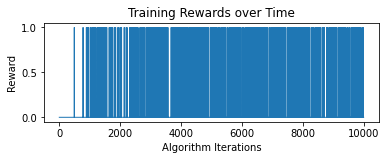

In [8]:
#Main Method decides which environment to agent combo to run
#*****Uncomment the desired one
#Alter plot title to suit respective environment in Driver class
if __name__ == '__main__':
    #frozen_lake_random()
    frozen_lake_qlearner()
    #frozen_lake_tdlearner()
    #cartpole_tdlearner()
    #cartpole_qlearner()